In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import numpy as np
from pathlib import Path

## Tract map intersection with 10km_grid

In [13]:
#unit_gdf = gpd.read_file('../shapefiles/tl_2020_06_tract/tl_2020_06_tract.shp')
unit_gdf = gpd.read_file('../WesternUSCensusTract/CensusTract2020_WesternUS.shp')

<Axes: >

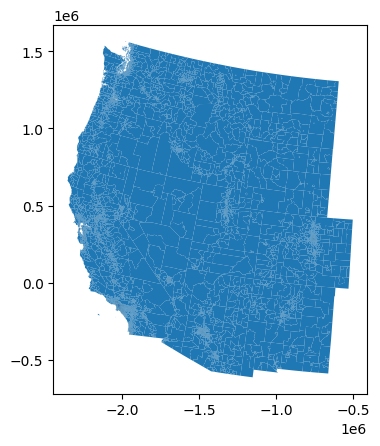

In [14]:
unit_gdf.plot()

In [15]:
grid_10km = gpd.read_file('10km_grid_wgs84/10km_grid_wgs84.shp')

In [16]:
grid_10km = grid_10km.to_crs(unit_gdf.crs)

In [17]:
# make a crosswalk with intersection area with grid cells
unit_cross = gpd.overlay(unit_gdf, grid_10km, how='intersection')

In [18]:
unit_cross = unit_cross.to_crs('EPSG:2227')

In [19]:
unit_cross['area'] = unit_cross.geometry.area

In [22]:
unit_cross.head()

,STATE_ABBR,STATE_FIPS,COUNTY_FIP,STCOFIPS,TRACT_FIPS,FIPS,POPULATION,POP_SQMI,SQMI,Shape_Leng,Shape_Area,ID,COORDX,COORDY,geometry,area
0,AZ,04,001,04001,942600,04001942600,1549,2.6,589.09,232812.475761,1.525731e+09,111363,-3240000.0,4910000.0,"POLYGON ((9679403.887 1803846.784, 9679295.446...",1.468923e+08
1,AZ,04,001,04001,944301,04001944301,3789,7.8,483.94,298531.868452,1.253386e+09,111363,-3240000.0,4910000.0,"POLYGON ((9656614.561 1790678.144, 9657524.553...",6.308409e+08
2,AZ,04,001,04001,942600,04001942600,1549,2.6,589.09,232812.475761,1.525731e+09,111364,-3230000.0,4910000.0,"POLYGON ((9680054.177 1807653.268, 9680631.466...",4.405904e+06
3,AZ,04,001,04001,942700,04001942700,4491,3.9,1155.35,494105.485641,2.992333e+09,111364,-3230000.0,4910000.0,"POLYGON ((9707393.005 1812212.798, 9707270.968...",2.643490e+08
4,AZ,04,001,04001,944301,04001944301,3789,7.8,483.94,298531.868452,1.253386e+09,111364,-3230000.0,4910000.0,"POLYGON ((9679472.246 1803867.771, 9679502.356...",5.102443e+08


In [46]:
len(unit_cross.FIPS.unique())

18108

In [23]:
unit_cross = unit_cross[['FIPS', 'ID', 'area']]

## Load population

In [24]:
csv_files = [
    "populationDensity_10km_subgrid_1.csv",
    "populationDensity_10km_subgrid_2.csv",
    "populationDensity_10km_subgrid_3.csv",
    "populationDensity_10km_subgrid_4.csv",
    "populationDensity_10km_subgrid_5.csv",
    "populationDensity_10km_subgrid_6.csv",
    "populationDensity_10km_subgrid_7.csv",
    "populationDensity_10km_subgrid_8.csv",
    "populationDensity_10km_subgrid_9.csv",
    "populationDensity_10km_subgrid_10.csv",
]

# Read and combine CSV files
dfs = [pd.read_csv("populationDensity_10km_subgrid/"+file) for file in csv_files]
pop = pd.concat(dfs, ignore_index=True)

## Load Smoke PM

In [25]:
df = pd.read_csv('smokePM2pt5_predictions_daily_10km_20060101-20201231.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

## Get only 2020 for Space

In [ ]:
len(df)

In [ ]:
# df = df[df["date"].dt.year==2020]

In [ ]:
len(df)

## Get weighted average on Tract

In [26]:
# loop through work with one date at a time, concatenate the data frames from the dates
unique_dates = df['date'].unique()

In [27]:
def weighted_mean(df, values_col, weights_col):
    temp = (df[values_col] * df[weights_col]).sum()
    if temp:
        return temp / df[weights_col].sum()
    return temp

In [28]:
smoke_pm = df

In [31]:
unit_cross.head()

,FIPS,ID,area
0,04001942600,111363,1.468923e+08
1,04001944301,111363,6.308409e+08
2,04001942600,111364,4.405904e+06
3,04001942700,111364,2.643490e+08
4,04001944301,111364,5.102443e+08


In [32]:
avg_unit_smoke_pm = []
for date in unique_dates:
    smoke_pm_date = smoke_pm[smoke_pm['date'] == date]

    smoke_pm_date_joined = unit_cross.merge(smoke_pm_date, left_on='ID', right_on='grid_id_10km', how='left')
    smoke_pm_date_joined = smoke_pm_date_joined.merge(pop, on='ID', how='left')

    smoke_pm_date_joined['smokePM_pred'] = smoke_pm_date_joined['smokePM_pred'].fillna(0)
    smoke_pm_date_joined['pop'] = smoke_pm_date_joined['mean'] * smoke_pm_date_joined['area']

    smoke_pm_date_agg = smoke_pm_date_joined.groupby(['FIPS']).apply(
        lambda x: weighted_mean(x, 'smokePM_pred', 'pop')).reset_index()

    #smoke_pm_date_agg.columns = ['GEOID', 'date', 'smokePM_pred']
    smoke_pm_date_agg["date"] = date
    avg_unit_smoke_pm.append(smoke_pm_date_agg)

avg_unit_smoke_pm = pd.concat(avg_unit_smoke_pm, ignore_index=True)

In [33]:
avg_unit_smoke_pm[avg_unit_smoke_pm[0] != 0]

,FIPS,0,date
14172,35025000100,11.146481,2006-01-01
14173,35025000200,11.309841,2006-01-01
14174,35025000300,10.799630,2006-01-01
14175,35025000400,11.137139,2006-01-01
14176,35025000502,11.146481,2006-01-01
...,...,...,...
97929826,04027980004,0.590623,2020-12-31
97929827,04027980005,3.658595,2020-12-31
97929828,04027980006,0.003443,2020-12-31
97930901,06025012400,0.635760,2020-12-31


In [34]:
avg_unit_smoke_pm = avg_unit_smoke_pm.rename(columns= {0:"smoke_pm"})

In [35]:
# Save the aggregated PM2.5 data
# avg_unit_smoke_pm.to_csv("smoke_pm_2020.csv", index=False)

In [40]:
# Save the aggregated PM2.5 data
avg_unit_smoke_pm.to_parquet("smoke_pm_all_time_2020_map.parquet")

In [44]:
avg_unit_smoke_pm.to_parquet("smoke_pm_all_time_2020_map_backup.parquet")

In [45]:
len(avg_unit_smoke_pm.FIPS.unique())

18108

In [41]:
avg_unit_smoke_pm.head()

,FIPS,smoke_pm,date
0,04001942600,0.0,2006-01-01
1,04001942700,0.0,2006-01-01
2,04001944000,0.0,2006-01-01
3,04001944100,0.0,2006-01-01
4,04001944201,0.0,2006-01-01


In [42]:
avg_unit_smoke_pm.date.min()

Timestamp('2006-01-01 00:00:00')

In [43]:
len(avg_unit_smoke_pm)

97946172

## Test & compare

In [21]:
!pwd

/Users/ant746/PycharmProjects/kate/data/smoke_pm


In [23]:
smoke_df = pd.read_parquet("../../outputs/smoke_pm25_predicted_with_fips.parquet")

In [24]:
smoke_df.head()

,GEOID,smokePM_pred,FIPS,time
index,,,,
0,6025010101,2.294267,2677.0,2006-01-03
1,6025010101,1.291195,2677.0,2006-01-05
2,6025010101,3.173662,2677.0,2006-01-06
3,6025010101,1.147731,2677.0,2006-01-09
4,6025010101,1.624987,2677.0,2006-01-20


In [28]:
smoke_df.dtypes

GEOID                    int64
smokePM_pred           float64
FIPS                   float64
time            datetime64[ns]
dtype: object

In [29]:
avg_unit_smoke_pm['GEOID']=avg_unit_smoke_pm['GEOID'].astype(int)

In [30]:
fin = avg_unit_smoke_pm.merge(smoke_df, left_on=['GEOID','date'], right_on=['GEOID','time'])

In [32]:
fin["diff"]=fin["smokePM_pred"]-fin["smoke_pm"]

In [44]:
fin["diff"]=np.abs(fin["diff"]).round()

In [45]:
fin["diff"].describe()

count    2.599011e+06
mean     8.172339e-04
std      5.645768e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.300000e+01
Name: diff, dtype: float64